In [87]:
# Copyright 2019 Steven Mattis and Troy Butler
import numpy as np
import matplotlib.pyplot as plt
import dynamical_systems as ds
from luq import *

Model is for harmonic motion
$$y''(t) + 2cy'(t) + \omega_0^2 x = f(t)$$
with damping constant
$$c \in [0.1,1]$$
and natural frequency
$$\omega_0\in[0.5,2]$$
and forcing term initially taken to be zero.

Note that with the ranges of $c$ and $\omega_0$ above, it is possible for the system to either be under-, over-, or critically damped (and since $c\geq 0.1$ it is never undamped, which is almost always physical nonsense). 

The roots to the characteristic equation are given by
$$ r_1 = -c\pm \sqrt{c^2-\omega_0^2}$$.

When the system is under-damped, the solution is given by
$$ y(t) = e^{-ct}[C_1\cos(\omega t) + C_2\sin(\omega t)], \ \omega=\sqrt{\omega_0^2-c^2}. $$


When the system is over-damped, the solution is given by 
$$ y(t) = C_1 e^{r_1t}+C_2 e^{r_2t}. $$

And, finally, when the system is critically damped, the solution is given by
$$ y(t) = C_1e^{-ct} + C_2 te^{-ct}. $$

However, we never expect the system to be critically damped in practice since this is "too fine-tuned" of a scenario. 

The constants $C_1$ and $C_2$ are determined by the initial conditions, which we assume to be given by
$$ y(0)=a, y'(0) = b $$
where 
$$ a\in[1,2] $$ 
and 
$$ b\in[-1,0] $$. 

In the under-damped case, 
$$ C_1 = a, \ \text{and } \ C_2 = \frac{b+ca}{\omega}. $$

In the over-damped case, 
$$ C_1 = \frac{b-ar_2}{r_1-r_2}, \ \text{and } \ C_2 = \frac{b-r_1a}{r_2-r_1} $$

A ***true*** distribution of $c, \omega_0, a$, and $b$ are defined by (non-uniform)
Beta distributions and used to generate a set of time series data.

An ***initial*** uniform distribution is assumed and updated by the true time series data.

In [88]:
# Uniformly sample the parameter samples to form a "prediction" or "test" set
num_samples = int(1E3)

params = np.random.uniform(size=(num_samples, 2))
ics = np.random.uniform(size=(num_samples, 2))

param_range = np.array([[0.1, 0.5],  # c
                        [0.5, 2.0]])  # omega_0
ic_range = np.array([[1.0, 2.0],  #a
                     [-1.0, 0.0]])  #b
params = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params
ics = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics
param_labels = [r'$c$', r'$\omega_0$']
ic_labels = [r'$a$', r'$b$']

# Construct the predicted time series data

num_time_preds = int(50)  # number of predictions (uniformly space) between [time_start,time_end]
time_start = 0.5
time_end = 3.5
times = np.linspace(time_start, time_end, num_time_preds)

phys = ds.HarmonicOscillator()
predicted_time_series = phys.solve(ics=ics, params=params, t_eval=times)


# Simulate an observed Beta distribution of time series data

num_obs = int(1E3)

true_a = 2
true_b = 2

params_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
ics_obs = np.random.beta(size=(num_obs, 2), a=true_a, b=true_b)
params_obs = param_range[:, 0] + (param_range[:, 1] - param_range[:, 0]) * params_obs
ics_obs = ic_range[:, 0] + (ic_range[:, 1] - ic_range[:, 0]) * ics_obs

observed_time_series = phys.solve(ics=ics_obs, params=params_obs, t_eval=times)

# Add noise if desired
with_noise = False
noise_stdev = 0.05

if with_noise:
    observed_time_series += noise_stdev * np.random.randn(num_obs)

In [89]:
# Use LUQ to learn dynamics and QoIs
learn = LUQ(predicted_time_series, observed_time_series, times)

# time array indices over which to use
time_start_idx = 0
time_end_idx = 49

# Clean data
learn.clean_data(time_start_idx=time_start_idx, time_end_idx=time_end_idx,
                     num_clean_obs=50, tol=1.0e-2, min_knots=5, max_knots=15)

0 6 0.0022087466360091864
0 6 knots being used with error of 0.0022087466360091864
1 6 0.014049150584848282
1 7 0.009588154948286364
1 8 0.007221560407631862
1 9 0.006184263634111628
1 10 0.005297447875807926
1 10 knots being used with error of 0.005297447875807926
2 6 0.012907936073021214
2 7 0.009400497906235816
2 8 0.00738213050557373
2 9 0.005831714706329117
2 9 knots being used with error of 0.005831714706329117
3 6 0.01506923290420932
3 7 0.01475251228636759
3 8 0.009124826074313905
3 9 0.007185525231118196
3 10 0.005804781579146074
3 10 knots being used with error of 0.005804781579146074
4 6 0.030492990097352665
4 7 0.020410744371802104
4 8 0.01606402224121866
4 9 0.013405462248096833
4 10 0.010621344797580114
4 11 0.008887961942578322
4 12 0.008614564153617606
4 12 knots being used with error of 0.008614564153617606
5 6 0.004047809532790603
5 6 knots being used with error of 0.004047809532790603
6 6 0.04473275870431342
6 7 0.027658438350352886
6 8 0.019406860013519187
6 9 0.016

/Users/smattis/src/anaconda3/anaconda3/envs/loq.py/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


15 8 0.011356621460098741
15 9 0.008129260777942402
15 10 0.006114238973472416
15 11 0.0051046208883131945
15 11 knots being used with error of 0.0051046208883131945
16 6 0.04152894340316842
16 7 0.026102126031928984
16 8 0.018868874822719515
16 9 0.015371125509624045
16 10 0.012518841278288041
16 11 0.010603598097000533
16 12 0.009113702983591288
16 13 0.0072768813085848745
16 13 knots being used with error of 0.0072768813085848745
17 6 0.001439320137405741
17 6 knots being used with error of 0.001439320137405741
18 6 0.010465345998540295
18 7 0.007675048401809699
18 8 0.006099872016802877
18 9 0.00458262775089058
18 9 knots being used with error of 0.00458262775089058
19 6 0.011919979762798684
19 7 0.007999640313672294
19 8 0.0056710890724212416
19 9 0.0045812787277856835
19 9 knots being used with error of 0.0045812787277856835
20 6 0.02125887711932881
20 7 0.016503811009930723
20 8 0.01653069710712
20 9 0.010438420581233142
20 10 0.00942277307627552
20 11 0.007966291293113131
20 12

62 7 0.011493412097847374
62 8 0.008277643138509786
62 9 0.0063442807141851675
62 10 0.005307497095073768
62 10 knots being used with error of 0.005307497095073768
63 6 0.01352127218281981
63 7 0.01332270350254919
63 8 0.0076991064306108315
63 9 0.0059167414482532606
63 10 0.004894485667763486
63 10 knots being used with error of 0.004894485667763486
64 6 0.0086642558581927
64 7 0.005800165669705014
64 7 knots being used with error of 0.005800165669705014
65 6 0.029443828199262567
65 7 0.02098631191054572
65 8 0.015182224367668433
65 9 0.01266068619729721
65 10 0.01007123120383144
65 11 0.008575603897374549
65 12 0.007648147906783853
65 12 knots being used with error of 0.007648147906783853
66 6 0.013441748695443737
66 7 0.009130323243641263
66 8 0.006665316410117331
66 9 0.005308579855819983
66 9 knots being used with error of 0.005308579855819983
67 6 0.025788373106662894
67 7 0.013641484426424032
67 8 0.010101510366042265
67 9 0.007866991664591491
67 10 0.008198187441055715
67 11 0.

112 12 0.00712838598815483
112 12 knots being used with error of 0.00712838598815483
113 6 0.005595775455466356
113 6 knots being used with error of 0.005595775455466356
114 6 0.01453952025227938
114 7 0.008918361348480822
114 8 0.006232689042745307
114 9 0.005096962755969965
114 9 knots being used with error of 0.005096962755969965
115 6 0.013520566434342294
115 7 0.009123693826206699
115 8 0.006412250783838843
115 9 0.0049629705816370325
115 9 knots being used with error of 0.0049629705816370325
116 6 0.040621354453647195
116 7 0.026400740102348136
116 8 0.01831807904307059
116 9 0.014944307696137556
116 10 0.01244389803401732
116 11 0.010396924811799373
116 12 0.009073232618938736
116 13 0.007213355087000152
116 13 knots being used with error of 0.007213355087000152
117 6 0.026619840741941632
117 7 0.020809270499975514
117 8 0.01485060030626658
117 9 0.012727919679987878
117 10 0.011666165468160105
117 11 0.008681401498576987
117 12 0.00826025483318911
117 12 knots being used with e

162 6 0.026957061969096283
162 7 0.021058564206769388
162 8 0.0150030911941275
162 9 0.01230974016502864
162 10 0.009676705235518165
162 11 0.00818817340385122
162 12 0.00704313613200474
162 12 knots being used with error of 0.00704313613200474
163 6 0.0019550518217009076
163 6 knots being used with error of 0.0019550518217009076
164 6 0.014310028580141246
164 7 0.014322902959598585
164 8 0.009367895215981034
164 9 0.00731917143777109
164 10 0.005924501247636151
164 10 knots being used with error of 0.005924501247636151
165 6 0.011317291016102399
165 7 0.007540632661598484
165 8 0.005290182803573176
165 9 0.004248816975918319
165 9 knots being used with error of 0.004248816975918319
166 6 0.0041668946689691075
166 6 knots being used with error of 0.0041668946689691075
167 6 0.007703969569213034
167 7 0.005199193331283256
167 7 knots being used with error of 0.005199193331283256
168 6 0.03690813927819587
168 7 0.026136506931285487
168 8 0.022476685475954623
168 9 0.015167482887888682
16

209 10 0.006329547212828549
209 11 0.005240312497984579
209 11 knots being used with error of 0.005240312497984579
210 6 0.024021993529947903
210 7 0.013860506653200329
210 8 0.009976894740635213
210 9 0.007737375157231234
210 10 0.006611822684278821
210 10 knots being used with error of 0.006611822684278821
211 6 0.004658725888283964
211 6 knots being used with error of 0.004658725888283964
212 6 0.011343528300401199
212 7 0.008961329778681854
212 8 0.007888182150408672
212 9 0.005150514715460698
212 9 knots being used with error of 0.005150514715460698
213 6 0.021516332401722207
213 7 0.01319143388877013
213 8 0.010270700572376406
213 9 0.008866186104761207
213 10 0.008674896623821593
213 11 0.006779079294728665
213 12 0.005830845338179781
213 12 knots being used with error of 0.005830845338179781
214 6 0.03927047906789618
214 7 0.026322824109259308
214 8 0.018353265525773058
214 9 0.0149340572058569
214 10 0.012523528909716385
214 11 0.010154403097147904
214 12 0.009156755250591474


258 7 0.014147001466993325
258 8 0.01049335019657601
258 9 0.008871707547025914
258 10 0.0076598607353836065
258 11 0.007661325456251465
258 12 0.005837324201057601
258 12 knots being used with error of 0.005837324201057601
259 6 0.012768725968537821
259 7 0.009322090945967393
259 8 0.006861932681272343
259 9 0.005316355989895812
259 9 knots being used with error of 0.005316355989895812
260 6 0.04068208204986139
260 7 0.027673443136526272
260 8 0.024201578149037006
260 9 0.01612857956314935
260 10 0.0135447573070359
260 11 0.01104477689637631
260 12 0.009654767203316721
260 13 0.00757627027826374
260 13 knots being used with error of 0.00757627027826374
261 6 0.01135923265000174
261 7 0.008515608928690539
261 8 0.006466620382408975
261 9 0.004894339862204461
261 9 knots being used with error of 0.004894339862204461
262 6 0.013460802431719454
262 7 0.00961459406401154
262 8 0.007758216079043907
262 9 0.006127815804918923
262 10 0.005010532425835696
262 10 knots being used with error of 

305 7 0.022841571529463256
305 8 0.0158520997802665
305 9 0.01231003128989257
305 10 0.010715375311966776
305 11 0.008667663465158286
305 12 0.007231543563404715
305 12 knots being used with error of 0.007231543563404715
306 6 0.013732886948614142
306 7 0.010705281316048016
306 8 0.008610086957025712
306 9 0.00661396577909603
306 10 0.00534024791410635
306 10 knots being used with error of 0.00534024791410635
307 6 0.012231724367880328
307 7 0.007690128143749731
307 8 0.0052520548897728525
307 9 0.004300879019848692
307 9 knots being used with error of 0.004300879019848692
308 6 0.027015447351501857
308 7 0.02073760396908438
308 8 0.014896466030569128
308 9 0.012416248490685445
308 10 0.010198445685749527
308 11 0.008308066816488883
308 12 0.007023406834405323
308 12 knots being used with error of 0.007023406834405323
309 6 0.013611336826377975
309 7 0.01017789792435012
309 8 0.01046906522285302
309 9 0.00848114615994382
309 10 0.006259166405760021
309 11 0.005401137319913
309 11 knots

353 6 0.03871706063150994
353 7 0.023116848343075393
353 8 0.017865707841446577
353 9 0.014635347543172594
353 10 0.01207939512357233
353 11 0.01019490299579346
353 12 0.008974811227245583
353 13 0.007141275980334876
353 13 knots being used with error of 0.007141275980334876
354 6 0.004183119096337147
354 6 knots being used with error of 0.004183119096337147
355 6 0.02583491978870201
355 7 0.01721176044716556
355 8 0.013199970449974924
355 9 0.01068881050323575
355 10 0.00874260223567248
355 11 0.007456894471906388
355 12 0.00600604982631561
355 12 knots being used with error of 0.00600604982631561
356 6 0.012896826356900239
356 7 0.008834689649879855
356 8 0.006248614972895739
356 8 knots being used with error of 0.006248614972895739
357 6 0.005086899719808491
357 6 knots being used with error of 0.005086899719808491
358 6 0.012267577672974166
358 7 0.00830153785370704
358 8 0.0059034111851177995
358 9 0.004874434140401116
358 9 knots being used with error of 0.004874434140401116
359 

400 11 0.010729681639925968
400 12 0.00921309349791943
400 13 0.007305164148877309
400 13 knots being used with error of 0.007305164148877309
401 6 0.01395527539050232
401 7 0.009302168295082541
401 8 0.006783599423998152
401 9 0.005347788348470399
401 9 knots being used with error of 0.005347788348470399
402 6 0.0038405767310743105
402 6 knots being used with error of 0.0038405767310743105
403 6 0.0016005301501864095
403 6 knots being used with error of 0.0016005301501864095
404 6 0.028043238801686864
404 7 0.021271514655829202
404 8 0.015306097893851062
404 9 0.012018539760559447
404 10 0.010444561176013136
404 11 0.008504602712104832
404 12 0.007589467763307122
404 12 knots being used with error of 0.007589467763307122
405 6 0.0032179603342156267
405 6 knots being used with error of 0.0032179603342156267
406 6 0.04410132340630505
406 7 0.026395004069503868
406 8 0.0189173632926156
406 9 0.015681820729148595
406 10 0.012827324575706298
406 11 0.010951834468430009
406 12 0.00935156512

449 9 0.014366835489592798
449 10 0.011713379792601562
449 11 0.00946352998319132
449 12 0.008447214678889613
449 12 knots being used with error of 0.008447214678889613
450 6 0.027147562753861657
450 7 0.019354518406528513
450 8 0.014444173951403872
450 9 0.012012475237971726
450 10 0.00971277173679199
450 11 0.008159612170390403
450 12 0.0068830778545119105
450 12 knots being used with error of 0.0068830778545119105
451 6 0.031156692529793622
451 7 0.021198021644923012
451 8 0.01545872506034394
451 9 0.01312168064119165
451 10 0.011717495294401229
451 11 0.009809090773360406
451 12 0.007763060930747774
451 12 knots being used with error of 0.007763060930747774
452 6 0.0017760616506004479
452 6 knots being used with error of 0.0017760616506004479
453 6 0.021864516805785477
453 7 0.016481420846921793
453 8 0.01396960862999691
453 9 0.010756316288071449
453 10 0.009057371256540894
453 10 knots being used with error of 0.009057371256540894
454 6 0.009722924758937709
454 7 0.00662650006144

496 10 0.006563061780314302
496 11 0.005432777332347701
496 11 knots being used with error of 0.005432777332347701
497 6 0.0070712653310279865
497 6 knots being used with error of 0.0070712653310279865
498 6 0.003804866525775272
498 6 knots being used with error of 0.003804866525775272
499 6 0.00529442875590841
499 6 knots being used with error of 0.00529442875590841
500 6 0.0008272894853013321
500 6 knots being used with error of 0.0008272894853013321
501 6 0.004643484226969263
501 6 knots being used with error of 0.004643484226969263
502 6 0.039540838738146025
502 7 0.02731437255273816
502 8 0.023632171273528874
502 9 0.01588990630476474
502 10 0.013305462220442633
502 11 0.01086315853873964
502 12 0.009436290567277171
502 13 0.007518853818977836
502 13 knots being used with error of 0.007518853818977836
503 6 0.011701855091910596
503 7 0.00786762225608364
503 8 0.005600890687793505
503 9 0.004541227751731123
503 9 knots being used with error of 0.004541227751731123
504 6 0.012425207

547 8 0.015787202210083492
547 9 0.012946536386453858
547 10 0.011056532157909436
547 11 0.00885077269905232
547 12 0.007808474506153117
547 12 knots being used with error of 0.007808474506153117
548 6 0.025284469207106617
548 7 0.016358400333480873
548 8 0.015171037204604327
548 9 0.01046563030161481
548 10 0.008669359191273594
548 11 0.007218416244862459
548 12 0.006396406417008315
548 12 knots being used with error of 0.006396406417008315
549 6 0.006021484429700521
549 7 0.00408778148808713
549 7 knots being used with error of 0.00408778148808713
550 6 0.033011739940629496
550 7 0.020479309284393316
550 8 0.016041649977620247
550 9 0.01298673070864416
550 10 0.011475799552514324
550 11 0.00933033494583136
550 12 0.007604774124542691
550 12 knots being used with error of 0.007604774124542691
551 6 0.04142880724647464
551 7 0.026533280856489174
551 8 0.018967286884755644
551 9 0.015036058116451546
551 10 0.01247306739193396
551 11 0.011208037004883872
551 12 0.009136811346639283
551 1

595 6 0.01589371647505566
595 7 0.00983691963296119
595 8 0.00671197881282489
595 9 0.005453247812759526
595 9 knots being used with error of 0.005453247812759526
596 6 0.011259047023210721
596 7 0.007912781216668049
596 8 0.005702692964143371
596 9 0.004864714528442431
596 9 knots being used with error of 0.004864714528442431
597 6 0.008547131739789021
597 7 0.005429651224675921
597 7 knots being used with error of 0.005429651224675921
598 6 0.010230806540118528
598 7 0.006855066812471274
598 8 0.0047207486747355325
598 8 knots being used with error of 0.0047207486747355325
599 6 0.026984765616292785
599 7 0.02047488997694061
599 8 0.014548046824517016
599 9 0.01230041518372059
599 10 0.00991062290249532
599 11 0.008042352766382765
599 12 0.006912469869829104
599 12 knots being used with error of 0.006912469869829104
600 6 0.010524163227770614
600 7 0.009079984083110115
600 8 0.005477131675954334
600 9 0.0043056553840497575
600 9 knots being used with error of 0.0043056553840497575
60

640 6 0.008936132663177512
640 7 0.005724857153059153
640 7 knots being used with error of 0.005724857153059153
641 6 0.007236953176762506
641 7 0.004899306047074181
641 7 knots being used with error of 0.004899306047074181
642 6 0.003067621894273441
642 6 knots being used with error of 0.003067621894273441
643 6 0.013169330178609094
643 7 0.00959145187351905
643 8 0.0094830986549468
643 9 0.007207789102471188
643 10 0.007196668575209004
643 10 knots being used with error of 0.007196668575209004
644 6 0.026155746616751387
644 7 0.025235806933176192
644 8 0.014440796030450447
644 9 0.012156999444483915
644 10 0.011216744845880906
644 11 0.008480473707972754
644 12 0.007080511176853707
644 12 knots being used with error of 0.007080511176853707
645 6 0.003924233852206359
645 6 knots being used with error of 0.003924233852206359
646 6 0.010008092959454571
646 7 0.006903055458289363
646 8 0.004977166901918161
646 8 knots being used with error of 0.004977166901918161
647 6 0.0142521893570538

689 6 0.0018526111214910734
689 6 knots being used with error of 0.0018526111214910734
690 6 0.013110300294506712
690 7 0.008608802410850777
690 8 0.006109175837105278
690 9 0.0048470824023614635
690 9 knots being used with error of 0.0048470824023614635
691 6 0.013116434822217105
691 7 0.008748743430774985
691 8 0.0061086350251755095
691 9 0.004767994379332338
691 9 knots being used with error of 0.004767994379332338
692 6 0.013491739857130725
692 7 0.009107456317408641
692 8 0.006574814006487024
692 9 0.005224324569605662
692 9 knots being used with error of 0.005224324569605662
693 6 0.013915474751116994
693 7 0.008525916095945914
693 8 0.005853329385233003
693 9 0.004755065426792537
693 9 knots being used with error of 0.004755065426792537
694 6 0.006627562362975304
694 6 knots being used with error of 0.006627562362975304
695 6 0.02329802955303961
695 7 0.016846499734090945
695 8 0.013948910354754969
695 9 0.011505261436663071
695 10 0.009394921485982543
695 11 0.00832278038860292

734 7 0.010665864619449144
734 8 0.011119850156570682
734 9 0.008305332101004925
734 10 0.00627318682487078
734 11 0.005245695008355007
734 11 knots being used with error of 0.005245695008355007
735 6 0.014024233294754345
735 7 0.009377972712909159
735 8 0.006961921251077609
735 9 0.005378602521546819
735 9 knots being used with error of 0.005378602521546819
736 6 0.013781379999014246
736 7 0.010311298859010198
736 8 0.00908520684451215
736 9 0.006726905595535773
736 10 0.005745400329090426
736 10 knots being used with error of 0.005745400329090426
737 6 0.011871444543686695
737 7 0.008414824513904932
737 8 0.006038604799096968
737 9 0.004699034496760411
737 9 knots being used with error of 0.004699034496760411
738 6 0.00889575954853099
738 7 0.006271039757976285
738 7 knots being used with error of 0.006271039757976285
739 6 0.01572311686758454
739 7 0.01284426112741123
739 8 0.009333140972033504
739 9 0.007291156972599726
739 10 0.007069354294488567
739 11 0.005766991735141542
739 11

782 12 0.00893354420829323
782 13 0.007105303394129876
782 13 knots being used with error of 0.007105303394129876
783 6 0.03440182841563154
783 7 0.024954235181143977
783 8 0.0176281046687992
783 9 0.01487465959574607
783 10 0.011769894740985389
783 11 0.009868493987375573
783 12 0.00887579231310151
783 13 0.006911728255120116
783 13 knots being used with error of 0.006911728255120116
784 6 0.0006953497601990386
784 6 knots being used with error of 0.0006953497601990386
785 6 0.007491839826057414
785 7 0.0061045384246999086
785 7 knots being used with error of 0.0061045384246999086
786 6 0.008375022169648758
786 7 0.006384646410765633
786 7 knots being used with error of 0.006384646410765633
787 6 0.0007608863504453894
787 6 knots being used with error of 0.0007608863504453894
788 6 0.02623059165052888
788 7 0.015235221601774393
788 8 0.01051744223144358
788 9 0.00818447391681278
788 10 0.007137646380895748
788 11 0.006236980115447204
788 11 knots being used with error of 0.00623698011

837 6 0.015689986545764416
837 7 0.010385949086920322
837 8 0.00789371227258827
837 9 0.006103774195063273
837 10 0.00534883926792769
837 10 knots being used with error of 0.00534883926792769
838 6 0.013431945370305426
838 7 0.010080416269734044
838 8 0.008685057526832641
838 9 0.008097833415546348
838 10 0.0059339433219446095
838 11 0.005115630186870007
838 11 knots being used with error of 0.005115630186870007
839 6 0.004969389088003864
839 6 knots being used with error of 0.004969389088003864
840 6 0.012731287021333935
840 7 0.010851857562955074
840 8 0.006912075700445879
840 9 0.005289544625726143
840 9 knots being used with error of 0.005289544625726143
841 6 0.0046217060089642535
841 6 knots being used with error of 0.0046217060089642535
842 6 0.013103480052695127
842 7 0.013657015965953439
842 8 0.009381460020811597
842 9 0.007662851603427538
842 10 0.00666417848895737
842 11 0.005457981552061944
842 11 knots being used with error of 0.005457981552061944
843 6 0.0121138252392665

883 9 0.00484512030745342
883 9 knots being used with error of 0.00484512030745342
884 6 0.017086826377102814
884 7 0.011933055894411914
884 8 0.00878080097078931
884 9 0.006866301048779964
884 10 0.006155668195486483
884 11 0.004977961075497055
884 11 knots being used with error of 0.004977961075497055
885 6 0.014082385477508367
885 7 0.012590037371417463
885 8 0.00804679619110046
885 9 0.006322727063879703
885 10 0.005059724533418081
885 10 knots being used with error of 0.005059724533418081
886 6 0.013912703041114496
886 7 0.010857829132672626
886 8 0.007435785120767758
886 9 0.0058635219073815146
886 9 knots being used with error of 0.0058635219073815146
887 6 0.013345000579222428
887 7 0.009879914412764023
887 8 0.006717312638125
887 9 0.0053881162360428754
887 9 knots being used with error of 0.0053881162360428754
888 6 0.014906573405463017
888 7 0.010640603754279776
888 8 0.008061033997575505
888 9 0.00697052365422947
888 10 0.005758829822107673
888 11 0.004668949684783703
888 1

931 8 0.01704393229905023
931 9 0.01456315670080903
931 10 0.012041236376752846
931 11 0.009716598533893643
931 12 0.008438567793903638
931 12 knots being used with error of 0.008438567793903638
932 6 0.023288531519250553
932 7 0.015272617507315001
932 8 0.014780176726432274
932 9 0.010161134345525256
932 10 0.008420923238382722
932 11 0.007016483217958688
932 12 0.006462435656027785
932 12 knots being used with error of 0.006462435656027785
933 6 0.02258057263081568
933 7 0.013007345878048488
933 8 0.010139546302014406
933 9 0.008987699565885306
933 10 0.007978974332179135
933 11 0.006441606926291898
933 12 0.0054671770461263815
933 12 knots being used with error of 0.0054671770461263815
934 6 0.01450615780264428
934 7 0.009494492756449995
934 8 0.006878161705006037
934 9 0.00542731637845772
934 9 knots being used with error of 0.00542731637845772
935 6 0.039862803724838865
935 7 0.025905262743912496
935 8 0.02057444186191546
935 9 0.01625416504884815
935 10 0.013085568045940528
935 1

977 10 0.010291086880322228
977 11 0.008945642421729337
977 12 0.007477722461529977
977 12 knots being used with error of 0.007477722461529977
978 6 0.02295269117944134
978 7 0.0148197935078729
978 8 0.01213278856576301
978 9 0.00994144255940888
978 10 0.008631987308779687
978 11 0.007089830242643365
978 12 0.006165344540382638
978 12 knots being used with error of 0.006165344540382638
979 6 0.024466034790544378
979 7 0.017569987998414263
979 8 0.013722256677269236
979 9 0.010483125882973872
979 10 0.008752596578681706
979 11 0.007988744799505999
979 12 0.006213178004129703
979 12 knots being used with error of 0.006213178004129703
980 6 0.00972678164541808
980 7 0.00648156842983269
980 8 0.004464889367732325
980 8 knots being used with error of 0.004464889367732325
981 6 0.01274494783011372
981 7 0.009024756722115931
981 8 0.0075042370847708505
981 9 0.006453653736782768
981 9 knots being used with error of 0.006453653736782768
982 6 0.026683063702857814
982 7 0.02530489470704633
982 

25 6 0.021742112943792923
25 7 0.014292530873075259
25 8 0.010719874564506201
25 9 0.009099953129909591
25 10 0.007857606528378688
25 11 0.007466166347131689
25 12 0.005911449961953767
25 12 knots being used with error of 0.005911449961953767
26 6 0.024656861463721695
26 7 0.015206361180191946
26 8 0.011545377516763327
26 9 0.009326445238316687
26 10 0.008082550255127762
26 11 0.00648401041101542
26 12 0.005502583820770867
26 12 knots being used with error of 0.005502583820770867
27 6 0.016355733679149165
27 7 0.013715046946584694
27 8 0.009704223142107548
27 9 0.00772564868381935
27 10 0.00634676433387334
27 10 knots being used with error of 0.00634676433387334
28 6 0.026268899912189916
28 7 0.018285362780327104
28 8 0.013883849047862528
28 9 0.011673376146077042
28 10 0.009627675080010967
28 11 0.008231528503647084
28 12 0.007001741491433066
28 12 knots being used with error of 0.007001741491433066
29 6 0.022896854074240528
29 7 0.017725280100718277
29 8 0.013604366879398215
29 9 0.0

70 6 0.012272383547056679
70 7 0.008165720808559112
70 8 0.005793514184161863
70 9 0.0046536407779091925
70 9 knots being used with error of 0.0046536407779091925
71 6 0.007691579659450983
71 7 0.005149657521993643
71 7 knots being used with error of 0.005149657521993643
72 6 0.008406587287752686
72 7 0.006368329054197112
72 7 knots being used with error of 0.006368329054197112
73 6 0.009815795131825202
73 7 0.00639431347614973
73 8 0.004591436286835415
73 8 knots being used with error of 0.004591436286835415
74 6 0.02271834398284886
74 7 0.015022695919260422
74 8 0.015017903136528815
74 9 0.010361459658202527
74 10 0.008326462115888365
74 11 0.006988187421084627
74 11 knots being used with error of 0.006988187421084627
75 6 0.010859293704789288
75 7 0.007414265718014472
75 8 0.005537107658848096
75 8 knots being used with error of 0.005537107658848096
76 6 0.010588676707195994
76 7 0.00753169343842755
76 8 0.005700120470995617
76 8 knots being used with error of 0.005700120470995617
7

123 6 0.005408022374331419
123 6 knots being used with error of 0.005408022374331419
124 6 0.01391260002998859
124 7 0.009844731760834212
124 8 0.007869838519284052
124 9 0.007133756169807511
124 10 0.005495313592650161
124 10 knots being used with error of 0.005495313592650161
125 6 0.010361480515996445
125 7 0.006625178496588428
125 8 0.004438134130229869
125 8 knots being used with error of 0.004438134130229869
126 6 0.011300009252740752
126 7 0.008602150600273577
126 8 0.006296165293183405
126 9 0.004833222765257325
126 9 knots being used with error of 0.004833222765257325
127 6 0.00796454779911122
127 7 0.005602350099109286
127 7 knots being used with error of 0.005602350099109286
128 6 0.012692069146831854
128 7 0.008330378939210499
128 8 0.005897887346286651
128 9 0.004818803798227466
128 9 knots being used with error of 0.004818803798227466
129 6 0.025051042914444044
129 7 0.018301417540198043
129 8 0.013528946322016781
129 9 0.011871262103540062
129 10 0.009182965650908677
129

170 9 0.004787285600884569
170 9 knots being used with error of 0.004787285600884569
171 6 0.01500898527021669
171 7 0.014788898730654318
171 8 0.00948765992528335
171 9 0.007444505286591507
171 10 0.006105247826670696
171 10 knots being used with error of 0.006105247826670696
172 6 0.03443910279757099
172 7 0.020794795587595994
172 8 0.016532655874464015
172 9 0.0144508065597214
172 10 0.011186285763291712
172 11 0.009249647657012666
172 12 0.008636133916388138
172 12 knots being used with error of 0.008636133916388138
173 6 0.018975154691276398
173 7 0.014541651020812866
173 8 0.010362207762348717
173 9 0.008177024733560963
173 10 0.007171195885003477
173 11 0.00589953212599086
173 12 0.00521427699841165
173 12 knots being used with error of 0.00521427699841165
174 6 0.012461815196341567
174 7 0.008272759934637152
174 8 0.005842486374150218
174 9 0.004674704304185527
174 9 knots being used with error of 0.004674704304185527
175 6 0.0015462879632538256
175 6 knots being used with erro

217 9 0.009860279731599053
217 10 0.008462643255388919
217 11 0.007094840173331132
217 12 0.006436342642876415
217 12 knots being used with error of 0.006436342642876415
218 6 0.04189455011145494
218 7 0.026868710075526717
218 8 0.01862261108062468
218 9 0.01523725248379604
218 10 0.012692068993869423
218 11 0.010638708391216879
218 12 0.009254788388771827
218 13 0.00693772384338746
218 13 knots being used with error of 0.00693772384338746
219 6 0.013245462624462466
219 7 0.00879550847943877
219 8 0.0071320482996356915
219 9 0.005906645439711465
219 9 knots being used with error of 0.005906645439711465
220 6 0.03511151659996909
220 7 0.02463979831822167
220 8 0.017820720006693644
220 9 0.015001286020149829
220 10 0.012032222757580582
220 11 0.009444460022472038
220 12 0.00875950545495358
220 13 0.006846035485742201
220 13 knots being used with error of 0.006846035485742201
221 6 0.027569158490959488
221 7 0.019910462365222058
221 8 0.015121366952670174
221 9 0.01208626328780046
221 10 

262 12 0.005355216734702019
262 12 knots being used with error of 0.005355216734702019
263 6 0.024717625926659843
263 7 0.01810957702266512
263 8 0.013894474694423575
263 9 0.012139627477282052
263 10 0.0091936803948769
263 11 0.008264161310538552
263 11 knots being used with error of 0.008264161310538552
264 6 0.021821209592351176
264 7 0.013992621299024939
264 8 0.010343088293919382
264 9 0.0087497090144198
264 10 0.008143665554597026
264 10 knots being used with error of 0.008143665554597026
265 6 0.012739552296220131
265 7 0.012308983198996941
265 8 0.007328161465255957
265 9 0.005603518964853404
265 9 knots being used with error of 0.005603518964853404
266 6 0.02668296510182238
266 7 0.012933715081019181
266 8 0.009811978211342703
266 9 0.00820526302407019
266 10 0.008256807552524562
266 11 0.00608314802433589
266 12 0.005148963272929739
266 12 knots being used with error of 0.005148963272929739
267 6 0.01593895718501207
267 7 0.011809750001397577
267 8 0.010008887457199942
267 9 

311 11 0.008461873541735384
311 12 0.007214478886950034
311 12 knots being used with error of 0.007214478886950034
312 6 0.014576066032973513
312 7 0.009992236013086669
312 8 0.007659032046672131
312 9 0.006027980899558604
312 10 0.005867901428861509
312 11 0.004510757532991023
312 11 knots being used with error of 0.004510757532991023
313 6 0.012647259424989047
313 7 0.008386994015301392
313 8 0.005954503779000329
313 9 0.004770045487627241
313 9 knots being used with error of 0.004770045487627241
314 6 0.006703474229784485
314 7 0.0050111594014288505
314 7 knots being used with error of 0.0050111594014288505
315 6 0.014842492309755893
315 7 0.00958607386067696
315 8 0.006943616050575532
315 9 0.0053979702910768495
315 9 knots being used with error of 0.0053979702910768495
316 6 0.023535884824959104
316 7 0.014722909446679932
316 8 0.01063200777593313
316 9 0.00871925754149209
316 10 0.008659208148803244
316 11 0.006404334179765999
316 12 0.005284693408897484
316 12 knots being used w

358 10 0.006326626383377768
358 11 0.005395711199789908
358 11 knots being used with error of 0.005395711199789908
359 6 0.022440011991838246
359 7 0.014130513528393408
359 8 0.011471424902418344
359 9 0.009824102753684326
359 10 0.008274986234404615
359 11 0.006637811222815069
359 12 0.005738423704301896
359 12 knots being used with error of 0.005738423704301896
360 6 0.002245836139763051
360 6 knots being used with error of 0.002245836139763051
361 6 0.00779786824996469
361 7 0.005255741873261508
361 7 knots being used with error of 0.005255741873261508
362 6 0.015886869706727348
362 7 0.011454191923547493
362 8 0.00845320535592059
362 9 0.007360462467326377
362 10 0.005738290331059354
362 11 0.004852878310555509
362 11 knots being used with error of 0.004852878310555509
363 6 0.013202922985183852
363 7 0.009144143570830938
363 8 0.0070806884852164555
363 9 0.00661016516131078
363 9 knots being used with error of 0.00661016516131078
364 6 0.015156981872616326
364 7 0.0144732547084979

404 9 0.009532747488154527
404 10 0.008522379121665057
404 11 0.006621626306723246
404 12 0.005556417751703329
404 12 knots being used with error of 0.005556417751703329
405 6 0.03351281993369179
405 7 0.024578588403625007
405 8 0.0176219995797884
405 9 0.014844411616712053
405 10 0.011991787716168687
405 11 0.009445107906695022
405 12 0.00839928951700995
405 13 0.0067143260637367325
405 13 knots being used with error of 0.0067143260637367325
406 6 0.011045227571728907
406 7 0.008254831030842257
406 8 0.006070532995233919
406 9 0.004725326227979721
406 9 knots being used with error of 0.004725326227979721
407 6 0.013710739066941906
407 7 0.00994976909769174
407 8 0.008082828298370195
407 9 0.007379818923766347
407 10 0.005678433307732441
407 10 knots being used with error of 0.005678433307732441
408 6 0.012506581039290752
408 7 0.008408800706739486
408 8 0.006009065587564649
408 9 0.004987067179319857
408 9 knots being used with error of 0.004987067179319857
409 6 0.01281733765932164
4

453 6 0.01584016570744989
453 7 0.011624782078356299
453 8 0.009868305684649597
453 9 0.007233343069252714
453 10 0.00597104793848297
453 11 0.004852952646787269
453 11 knots being used with error of 0.004852952646787269
454 6 0.013747213034111912
454 7 0.009848664549071611
454 8 0.007143368145427624
454 9 0.005926860101941325
454 10 0.004826344949597653
454 10 knots being used with error of 0.004826344949597653
455 6 0.014110703365678726
455 7 0.011495997638135049
455 8 0.007731000415529371
455 9 0.006010903456604546
455 9 knots being used with error of 0.006010903456604546
456 6 0.014142968466145244
456 7 0.009476101147802375
456 8 0.0070938162263723585
456 9 0.005443450687593214
456 9 knots being used with error of 0.005443450687593214
457 6 0.027244378047885827
457 7 0.026022767704273548
457 8 0.015233255752750783
457 9 0.01184988614502418
457 10 0.011661109404476008
457 11 0.008732282340054846
457 12 0.006985207900718442
457 12 knots being used with error of 0.006985207900718442
4

498 10 0.00693150041156895
498 10 knots being used with error of 0.00693150041156895
499 6 0.02348709908858156
499 7 0.015522892708112397
499 8 0.014923879348094566
499 9 0.009724054701188454
499 10 0.008398888804543236
499 11 0.007013780142808699
499 12 0.006260362075915129
499 12 knots being used with error of 0.006260362075915129
500 6 0.011245362097639315
500 7 0.007889653179959273
500 8 0.005932800882639591
500 9 0.005111235784356293
500 9 knots being used with error of 0.005111235784356293
501 6 0.013202523366626915
501 7 0.008780538573491033
501 8 0.007199009929104801
501 9 0.0059816985904384825
501 9 knots being used with error of 0.0059816985904384825
502 6 0.005527028668698472
502 6 knots being used with error of 0.005527028668698472
503 6 0.013453867429042827
503 7 0.00841445399942525
503 8 0.0057140070296217964
503 9 0.004678808402997213
503 9 knots being used with error of 0.004678808402997213
504 6 0.005362062409162647
504 7 0.0036269139961970253
504 7 knots being used wi

547 8 0.007040476511588816
547 9 0.00549286700020776
547 9 knots being used with error of 0.00549286700020776
548 6 0.007075853674763652
548 7 0.005276004985382574
548 7 knots being used with error of 0.005276004985382574
549 6 0.02283732299061735
549 7 0.013867756428188273
549 8 0.010189917239963682
549 9 0.008322196752853676
549 10 0.006939948433969985
549 10 knots being used with error of 0.006939948433969985
550 6 0.021240819116118016
550 7 0.015652498699961097
550 8 0.016090345984954686
550 9 0.010736346155272204
550 10 0.00922510561983508
550 11 0.007822888599887421
550 12 0.00700639271900669
550 12 knots being used with error of 0.00700639271900669
551 6 0.01408123201550104
551 7 0.00878874198156957
551 8 0.005941037131268501
551 9 0.004850729577873605
551 9 knots being used with error of 0.004850729577873605
552 6 0.012687944560243174
552 7 0.008669779642632052
552 8 0.006249889533758668
552 9 0.004834866087213084
552 9 knots being used with error of 0.004834866087213084
553 6 

592 7 0.00840140157973779
592 8 0.006217543661702997
592 9 0.005086048006205398
592 9 knots being used with error of 0.005086048006205398
593 6 0.012780470316878179
593 7 0.00820951639355057
593 8 0.005883013040613197
593 9 0.004883105251796432
593 9 knots being used with error of 0.004883105251796432
594 6 0.01215439703904625
594 7 0.00894911292950566
594 8 0.006065574803206601
594 9 0.004870135309229536
594 9 knots being used with error of 0.004870135309229536
595 6 0.013202761116594465
595 7 0.009266531747158885
595 8 0.0074482497198245165
595 9 0.005915224411142584
595 9 knots being used with error of 0.005915224411142584
596 6 0.013591463472703205
596 7 0.010145252019612807
596 8 0.008638544636289323
596 9 0.009419962038277583
596 10 0.006196898676039498
596 11 0.005130796512103859
596 11 knots being used with error of 0.005130796512103859
597 6 0.013318734990915083
597 7 0.008278833726355617
597 8 0.0058281961278254845
597 9 0.004783865140178491
597 9 knots being used with error 

644 6 0.014965383051509391
644 7 0.010301405681470225
644 8 0.007945774019732618
644 9 0.007059035945301655
644 10 0.005714044076453043
644 11 0.00467677988411885
644 11 knots being used with error of 0.00467677988411885
645 6 0.013807370785478277
645 7 0.009889894858185633
645 8 0.007191831568987317
645 9 0.0060060622808854125
645 10 0.004724402541290217
645 10 knots being used with error of 0.004724402541290217
646 6 0.02338841180558587
646 7 0.013811852095166678
646 8 0.011217016052904394
646 9 0.01037294881803147
646 10 0.008150578603956345
646 11 0.006648334536296247
646 12 0.005212060868495869
646 12 knots being used with error of 0.005212060868495869
647 6 0.01309604549618379
647 7 0.010279727669489066
647 8 0.009341652787360518
647 9 0.007408691185685102
647 10 0.00689747971671081
647 10 knots being used with error of 0.00689747971671081
648 6 0.012032223835650049
648 7 0.009304354225393854
648 8 0.007159164124852649
648 9 0.00538392976091118
648 9 knots being used with error o

693 10 0.006365474646366415
693 10 knots being used with error of 0.006365474646366415
694 6 0.01374349845670581
694 7 0.009621930872861216
694 8 0.007236223912239139
694 9 0.006224133253031028
694 10 0.005170864403335683
694 10 knots being used with error of 0.005170864403335683
695 6 0.012900832306790594
695 7 0.010151529958344934
695 8 0.007501476151123238
695 9 0.005715461270923629
695 9 knots being used with error of 0.005715461270923629
696 6 0.005929253660994581
696 7 0.004109154431843539
696 7 knots being used with error of 0.004109154431843539
697 6 0.03080084274464129
697 7 0.021021540972242528
697 8 0.015711548284258067
697 9 0.015265506171739267
697 10 0.011012966691893711
697 11 0.009374847168007747
697 12 0.00783837711462569
697 12 knots being used with error of 0.00783837711462569
698 6 0.012282780886732129
698 7 0.009518474529549997
698 8 0.006410177747751514
698 9 0.00498287218832244
698 9 knots being used with error of 0.00498287218832244
699 6 0.03919190453306446
699

740 8 0.015857016026953677
740 9 0.013546833240708293
740 10 0.011845330592358719
740 11 0.010038402677607704
740 12 0.007936816089189336
740 12 knots being used with error of 0.007936816089189336
741 6 0.0006626085649364747
741 6 knots being used with error of 0.0006626085649364747
742 6 0.01175330509216488
742 7 0.007892763324938065
742 8 0.0055964024065412905
742 9 0.0045186445428698555
742 9 knots being used with error of 0.0045186445428698555
743 6 0.007676298556206309
743 7 0.005290736262116868
743 7 knots being used with error of 0.005290736262116868
744 6 0.012173574526483214
744 7 0.008141289257648012
744 8 0.005659700773859096
744 9 0.004435168349513802
744 9 knots being used with error of 0.004435168349513802
745 6 0.015168658220353494
745 7 0.014823643359769826
745 8 0.009452449300717657
745 9 0.007440481719494719
745 10 0.0061379616891223225
745 10 knots being used with error of 0.0061379616891223225
746 6 0.014075502230118938
746 7 0.009863532673517531
746 8 0.00781451313

787 9 0.004837487044638744
787 9 knots being used with error of 0.004837487044638744
788 6 0.040605112485616705
788 7 0.028104123674336755
788 8 0.02131970364793536
788 9 0.016176757172363374
788 10 0.013682086364608118
788 11 0.01135765155231787
788 12 0.009608076214084117
788 13 0.00767035836513611
788 13 knots being used with error of 0.00767035836513611
789 6 0.022538173528923094
789 7 0.014527198169174568
789 8 0.01086184058041063
789 9 0.00903772248639299
789 10 0.007514541089089897
789 11 0.0062687860816059955
789 11 knots being used with error of 0.0062687860816059955
790 6 0.013355596493339778
790 7 0.009764317962443182
790 8 0.007862594755681162
790 9 0.006108303974429328
790 10 0.005203198266518852
790 10 knots being used with error of 0.005203198266518852
791 6 0.009187423409161453
791 7 0.006123997060504015
791 7 knots being used with error of 0.006123997060504015
792 6 0.011549447049104829
792 7 0.008067721265056157
792 8 0.006069051179788099
792 9 0.005346835372446652
79

837 7 0.025289140599207914
837 8 0.015036467153838797
837 9 0.01207389614056857
837 10 0.011504604262482478
837 11 0.008310552848897266
837 12 0.00713707604388337
837 12 knots being used with error of 0.00713707604388337
838 6 0.02341846524937376
838 7 0.016088428015250164
838 8 0.013761558716312518
838 9 0.010687229934324805
838 10 0.00854636184621041
838 11 0.007122376072533847
838 11 knots being used with error of 0.007122376072533847
839 6 0.010671871644877907
839 7 0.00745555570648007
839 8 0.005440438891183929
839 8 knots being used with error of 0.005440438891183929
840 6 0.03379009566141502
840 7 0.021342814050767767
840 8 0.016546871744179792
840 9 0.014275344362661738
840 10 0.011410810450246972
840 11 0.009463276494574652
840 12 0.00873222412805085
840 12 knots being used with error of 0.00873222412805085
841 6 0.019373737221073283
841 7 0.010689944466040413
841 8 0.007361505565067439
841 9 0.005907747244848318
841 9 knots being used with error of 0.005907747244848318
842 6 

884 6 0.015416132737369335
884 7 0.016652913932328095
884 8 0.013238385538062388
884 9 0.008246229107798512
884 10 0.006712040592427547
884 11 0.005697001637330283
884 11 knots being used with error of 0.005697001637330283
885 6 0.005524505190782236
885 7 0.003739915852749561
885 7 knots being used with error of 0.003739915852749561
886 6 0.01284652914621014
886 7 0.009538321508966083
886 8 0.007427989625093174
886 9 0.006346780285138531
886 10 0.004923468052718215
886 10 knots being used with error of 0.004923468052718215
887 6 0.02312440643630312
887 7 0.017473907294082266
887 8 0.01377955363777711
887 9 0.011438094846204444
887 10 0.009481862280132388
887 10 knots being used with error of 0.009481862280132388
888 6 0.013722350794078525
888 7 0.010620607291023208
888 8 0.0105321550305839
888 9 0.009155965891347278
888 10 0.006489989653030826
888 11 0.005430806128782889
888 11 knots being used with error of 0.005430806128782889
889 6 0.012314917811600655
889 7 0.008936690004896206
889

932 8 0.013986116348541942
932 9 0.01204782013698052
932 10 0.009022897267419817
932 11 0.008187183273162136
932 12 0.006854193863132829
932 12 knots being used with error of 0.006854193863132829
933 6 0.012793873115340648
933 7 0.009751567179654422
933 8 0.008093054076638328
933 9 0.005969790534942066
933 10 0.004931468212567401
933 10 knots being used with error of 0.004931468212567401
934 6 0.008672234335782243
934 7 0.006966834060656992
934 7 knots being used with error of 0.006966834060656992
935 6 0.00955698566841168
935 7 0.006698352235090686
935 8 0.004860289243346457
935 8 knots being used with error of 0.004860289243346457
936 6 0.012976057972717617
936 7 0.012870668507941649
936 8 0.007496279227765955
936 9 0.0057409070773585405
936 10 0.004806117568996424
936 10 knots being used with error of 0.004806117568996424
937 6 0.014231381033092733
937 7 0.010731787032979136
937 8 0.009829724817406387
937 9 0.007091458123551051
937 10 0.005782174605871146
937 10 knots being used wit

977 6 0.02656422826773705
977 7 0.026203898007438078
977 8 0.01482225557160542
977 9 0.012578951110667478
977 10 0.011501901747979996
977 11 0.008342344107517658
977 12 0.008324618068759853
977 12 knots being used with error of 0.008324618068759853
978 6 0.016174637478814542
978 7 0.01367560491564932
978 8 0.00972313894079076
978 9 0.007844743720594195
978 10 0.006587083244094637
978 11 0.005576617739180138
978 11 knots being used with error of 0.005576617739180138
979 6 0.021771418720494602
979 7 0.014142696806438985
979 8 0.010554998624573132
979 9 0.008750697449715166
979 10 0.007268231580557442
979 11 0.0061666660486025164
979 11 knots being used with error of 0.0061666660486025164
980 6 0.011111691712357697
980 7 0.007081400420135722
980 8 0.004852312335193946
980 8 knots being used with error of 0.004852312335193946
981 6 0.00953639135462495
981 7 0.006362501857512833
981 8 0.004403554524644754
981 8 knots being used with error of 0.004403554524644754
982 6 0.01418311955645132
98

(array([[ 1.70801563,  1.67990483,  1.65179404, ..., -0.09574835,
         -0.12856333, -0.1613783 ],
        [ 0.81855038,  0.71916564,  0.61600782, ..., -0.05183176,
          0.03060366,  0.11303908],
        [ 1.16378496,  1.07572454,  0.98618039, ..., -0.38506182,
         -0.33586862, -0.28667541],
        ...,
        [ 1.18881787,  1.06882535,  0.94461621, ...,  0.22329069,
          0.26984627,  0.31640185],
        [ 0.6557233 ,  0.603294  ,  0.5508647 , ..., -0.93817391,
         -0.944544  , -0.95091409],
        [ 0.82123999,  0.70149516,  0.58175033, ...,  0.39914033,
          0.41001808,  0.42089582]]),
 array([[ 1.09877081,  1.01668001,  0.93458921, ..., -0.08594173,
         -0.05144153, -0.01694133],
        [ 1.30199518,  1.21794084,  1.13388651, ..., -0.2098061 ,
         -0.17704109, -0.14427607],
        [ 0.94218085,  0.88864159,  0.83510233, ..., -0.2723193 ,
         -0.2667691 , -0.26121889],
        ...,
        [ 1.2152778 ,  1.17162477,  1.12797174, ..., -

In [90]:
learn.dynamics()

0.011 misclassification rate for  {'kernel': 'linear'}
0.011 misclassification rate for  {'kernel': 'rbf'}
0.07999999999999999 misclassification rate for  {'kernel': 'poly'}
0.019 misclassification rate for  {'kernel': 'sigmoid'}
Best classifier is  {'kernel': 'rbf'}
Misclassification rate is  0.011


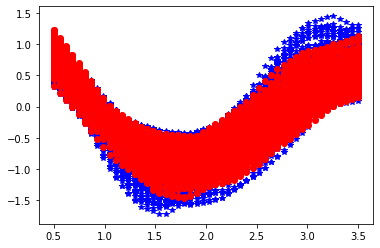

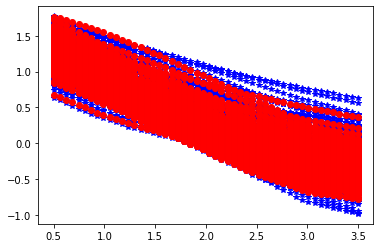

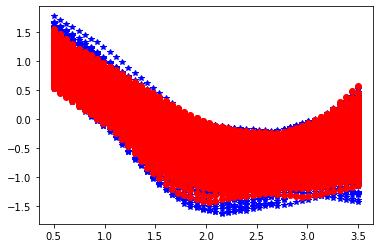

In [98]:
for j in range(learn.num_clusters):
    plt.figure()
    cluster_num = j
    for i in range(num_samples):
        if learn.predict_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_predictions[i,:],'b*')
    for i in range(num_obs):
        if learn.obs_labels[i] == cluster_num:
            plt.plot(learn.clean_times, learn.clean_obs[i,:],'ro')

In [92]:
predict_map, obs_map = learn.learn_qois_and_transform(num_qoi=4)

3 principal components explain 98.5353% of variance for cluster 0 with {'kernel': 'linear'}
22 principal components explain 95.1224% of variance for cluster 0 with {'kernel': 'rbf'}
7 principal components explain 95.0789% of variance for cluster 0 with {'kernel': 'sigmoid'}
9 principal components explain 95.7083% of variance for cluster 0 with {'kernel': 'poly'}
3 principal components explain 96.8968% of variance for cluster 0 with {'kernel': 'cosine'}
Best kPCA for cluster  0  is  {'kernel': 'linear'}
4 principal components explain 99.9309% of variance.
2 principal components explain 98.2548% of variance for cluster 1 with {'kernel': 'linear'}
13 principal components explain 95.2555% of variance for cluster 1 with {'kernel': 'rbf'}
5 principal components explain 96.1735% of variance for cluster 1 with {'kernel': 'sigmoid'}
6 principal components explain 96.5988% of variance for cluster 1 with {'kernel': 'poly'}
2 principal components explain 96.2891% of variance for cluster 1 with {'k

In [93]:
learn.generate_kdes()
r_vals = learn.compute_r()

r values: [0.9855067633601169, 0.9360179791222245, 1.079547705528319]


In [94]:
param_marginals = []
ic_marginals = []
true_param_marginals = []
true_ic_marginals = []
lam_ptr = []
cluster_weights = []
for i in range(learn.num_clusters):
    lam_ptr.append(np.where(learn.predict_labels == i)[0])
    cluster_weights.append(len(np.where(learn.obs_labels == i)[0]) / num_obs)

from scipy.stats import gaussian_kde as GKDE

for i in range(params.shape[1]):
    true_param_marginals.append(GKDE(params_obs[:,i]))
    param_marginals.append([])
    for j in range(learn.num_clusters):
        param_marginals[i].append(GKDE(params[lam_ptr[j], i], weights=learn.r[j]))
        
for i in range(ics.shape[1]):
    true_ic_marginals.append(GKDE(ics_obs[:,i]))
    ic_marginals.append([])
    for j in range(learn.num_clusters):
        ic_marginals[i].append(GKDE(ics[lam_ptr[j], i], weights=learn.r[j]))

In [95]:
def unif_dist(x, p_range):
    y = np.zeros(x.shape)
    val = 1.0/(p_range[1] - p_range[0])
    for i, xi in enumerate(x):
        if xi < p_range[0] or xi >  p_range[1]:
            y[i] = 0
        else:
            y[i] = val
    return y

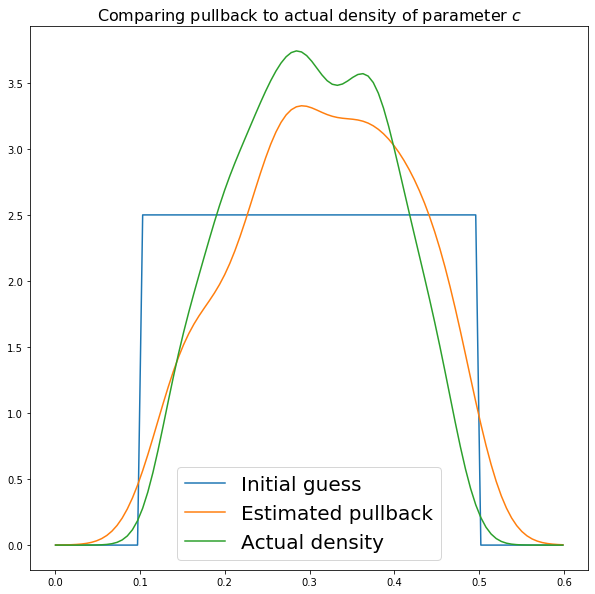

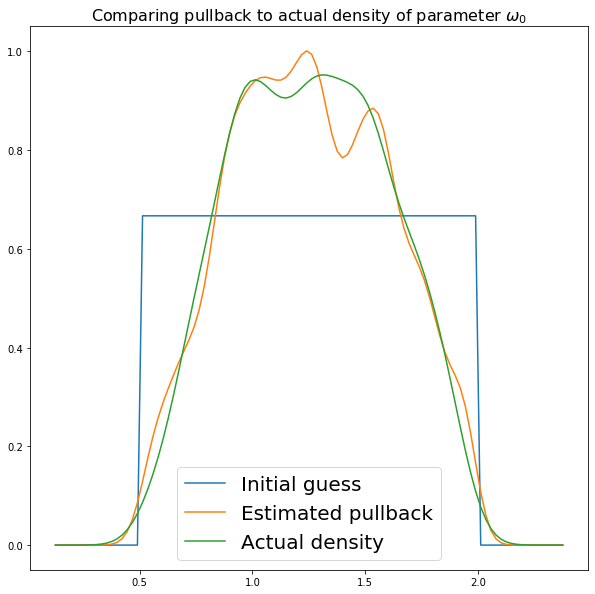

In [100]:
for i in range(params.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(params[:, i]), min(params_obs[:, i]))
    x_max = max(max(params[:, i]), max(params_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, param_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += param_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_param_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of parameter ' + param_labels[i], fontsize=16)
    plt.legend(fontsize=20)

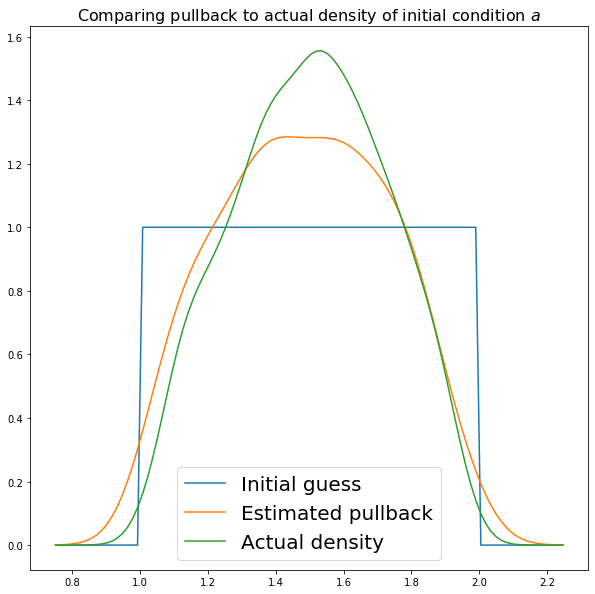

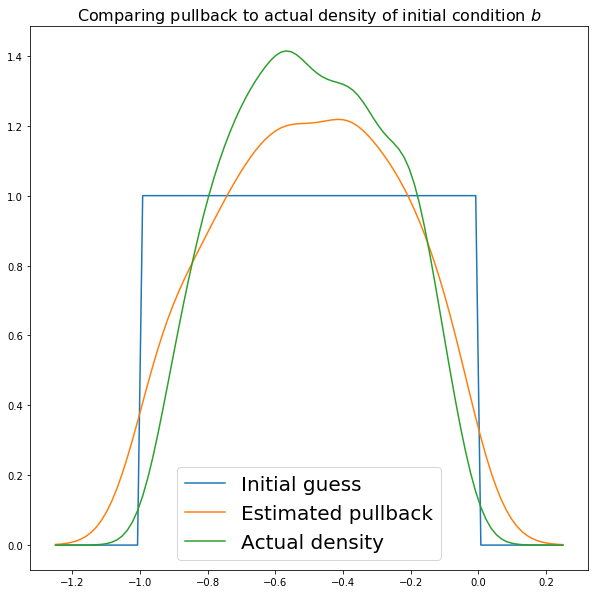

In [99]:
for i in range(ics.shape[1]):
    fig = plt.figure(figsize=(10,10))
    fig.clear()
    x_min = min(min(ics[:, i]), min(ics_obs[:, i]))
    x_max = max(max(ics[:, i]), max(ics_obs[:, i]))
    delt = 0.25*(x_max - x_min)
    x = np.linspace(x_min-delt, x_max+delt, 100)
    plt.plot(x, unif_dist(x, ic_range[i, :]),
         label = 'Initial guess')
    mar = np.zeros(x.shape)
    for j in range(learn.num_clusters):
        mar += ic_marginals[i][j](x) * cluster_weights[j]
    plt.plot(x, mar, label = 'Estimated pullback')
    plt.plot(x, true_ic_marginals[i](x), label = 'Actual density')
    plt.title('Comparing pullback to actual density of initial condition ' + ic_labels[i], fontsize=16)
    plt.legend(fontsize=20)